In [149]:
import pandas as pd
import numpy as np
import os
from typing import NoReturn
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [150]:
path_to_files = "data"
my_assets = ["^cry.txt", "^bet.txt", "^_us.txt", "^dax.txt", "^bvp.txt"]
path_to_output_files = "result_simple_day_roi"
os.makedirs(path_to_output_files, exist_ok=True)
delta_risk = 0.5
no_risk_return = 1e-6

In [151]:
def print_matrix(matrix: np.ndarray) -> NoReturn:
    print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in matrix]))

In [152]:
def simple_day_roi(table: pd.DataFrame) -> pd.Series:
    roi = []
    index = []
    for unique_day in np.unique(table.index):
        day_data = table.loc[unique_day, :]
        open_day = day_data.loc[:, "Open"][0]
        close_day = day_data.loc[:, "Close"][-1]
        roi.append((close_day - open_day) / open_day)
        index.append(unique_day)
    return pd.Series(roi, index=index)

In [153]:
all_rois = []
# дохідність
for data in my_assets:
    table = pd.read_csv(os.path.join(path_to_files, data), index_col=0)
    table.index = pd.to_datetime(table.index)
    simple_day = simple_day_roi(table)
    all_rois.append(simple_day)

In [154]:
# make all assets have common index (they have different size) and save to csv
index_sets = [set(roi.index) for roi in all_rois]
smallest_common_index = index_sets[0]
for index_set in index_sets[1:]:
    smallest_common_index = smallest_common_index.intersection(index_set)
all_rois = [roi.loc[smallest_common_index] for roi in all_rois]
for roi, asset in zip(all_rois, my_assets):
    roi.to_csv(os.path.join(path_to_output_files, asset), header=False, index=False)

In [155]:
array = np.concatenate([roi.values.reshape(-1, 1) for roi in all_rois], axis=1)
print("Mean", np.mean(array, axis=0))
print("Std", np.std(array, axis=0))
print("Correlation Matrix", np.corrcoef(array.transpose()))
print("Covariance Matrix", np.cov(array.transpose()))

Mean [ 0.00022049  0.00026171 -0.00050782 -0.00075983  0.00079256]
Std [0.00537909 0.00649839 0.00652502 0.0075066  0.01137786]
Correlation Matrix [[ 1.          0.14806197  0.37352434  0.06074526  0.39391373]
 [ 0.14806197  1.          0.25642696 -0.02895505  0.06559003]
 [ 0.37352434  0.25642696  1.          0.3100534   0.59644444]
 [ 0.06074526 -0.02895505  0.3100534   1.          0.27999273]
 [ 0.39391373  0.06559003  0.59644444  0.27999273  1.        ]]
Covariance Matrix [[ 2.92360582e-05  5.22948568e-06  1.32467727e-05  2.47836421e-06
   2.43596640e-05]
 [ 5.22948568e-06  4.26689658e-05  1.09863014e-05 -1.42716345e-06
   4.90009698e-06]
 [ 1.32467727e-05  1.09863014e-05  4.30193197e-05  1.53448122e-05
   4.47417048e-05]
 [ 2.47836421e-06 -1.42716345e-06  1.53448122e-05  5.69359547e-05
   2.41629982e-05]
 [ 2.43596640e-05  4.90009698e-06  4.47417048e-05  2.41629982e-05
   1.30804151e-04]]


In [156]:
frame = pd.DataFrame(array, columns=my_assets, index=all_rois[0].index)

In [ ]:
np.random.seed(42)
num_ports = 10000
all_weights = np.zeros((num_ports, len(frame.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
for x in tqdm(range(num_ports)):
    # Weights
    weights = np.array(np.random.random(len(frame.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (frame.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(frame.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = (ret_arr[x] - no_risk_return) /vol_arr[x]

In [ ]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(frame.mean() * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(frame.cov(), weights)))
    sr = (ret - no_risk_return) /vol
    return np.array([ret, vol, sr])

def min_shape_ratio(weights):
    return -get_ret_vol_sr(weights)[2]

def min_risk(weights):
    return get_ret_vol_sr(weights)[1]

def min_U(weights):
    return -(get_ret_vol_sr(weights)[0] - delta_risk * get_ret_vol_sr(weights)[1])


def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights) - 1

In [ ]:
#max U portfolio
cons = ({'type':'eq', 'fun':check_sum})
bounds =((0,1),(0,1),(0,1),(0,1),(0,1))
init = [0.3, 0.3, 0.05, 0.05, 0.3]
opt_res = minimize(min_U, init, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_res)
print(opt_res["x"])
print(get_ret_vol_sr(opt_res['x']))

In [ ]:
#min risk portfolio
cons = ({'type':'eq', 'fun':check_sum})
bounds =((0,1),(0,1),(0,1),(0,1),(0,1))
init = [0.3, 0.3, 0.05, 0.05, 0.3]
opt_res = minimize(min_risk, init, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_res)
print(opt_res["x"])
print(get_ret_vol_sr(opt_res['x']))

In [ ]:
#Tangency portfolio
cons = ({'type':'eq', 'fun':check_sum})
bounds =((0,1),(0,1),(0,1),(0,1),(0,1))
init = [0.3, 0.3, 0.05, 0.05, 0.3]
opt_res = minimize(min_shape_ratio, init, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_res)
print(opt_res["x"])
print(get_ret_vol_sr(opt_res['x']))
best_params = get_ret_vol_sr(opt_res['x'])

In [ ]:
# 0.006 is max return for my portfolio
frontier_y = np.linspace(0,0.0006,25)
frontier_x = []
for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(min_risk, init, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

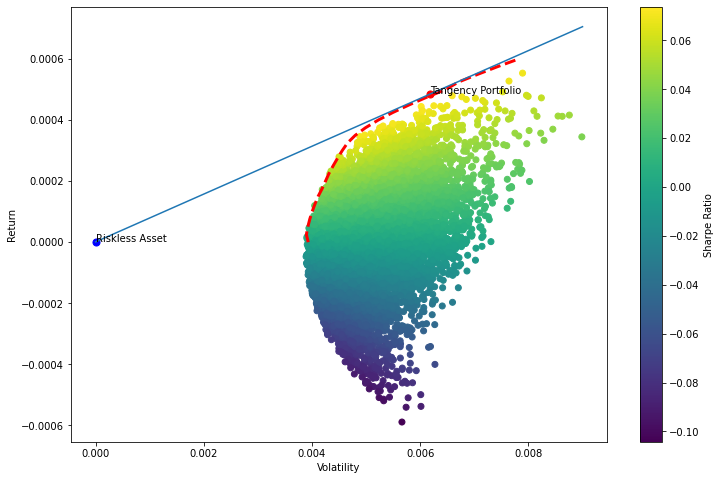

In [148]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(best_params[1], best_params[0], c='red', s=50) # red dot
plt.annotate("Tangency Portfolio", (best_params[1], best_params[0]))
plt.scatter(0, no_risk_return, c='blue', s=50) # blue dot
plt.annotate("Riskless Asset", (0, no_risk_return))
plt.savefig('cover.png')
line_x = np.linspace(0, 0.009, 50)
plt.plot(line_x, (line_x*best_params[2] + no_risk_return))
plt.show()
plt.show()